In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets, transforms

from sklearn.metrics import precision_score, recall_score, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

writer = SummaryWriter()

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256
EPOCHS = 40

print("Using device:", DEVICE)

Using device: cuda


# ***Helper Functions***

In [3]:
def load_dataset():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = datasets.USPS('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.USPS('./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)   
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, test_loader

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, 1)  
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(16 * 16, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
def train(model, data_loader, optimizer, criterion, epoch):
    model.train()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    running_acc = 0.0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()

        pred = output.argmax(dim=1, keepdim=True)
        running_acc += pred.eq(target.view_as(pred)).sum().item()

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = 100 * running_acc / len(data_loader.dataset)
    epoch_precision = precision_score(all_labels, all_preds, average='macro')
    epoch_recall = recall_score(all_labels, all_preds, average='macro')

    writer.add_scalar("Loss/Train", epoch_loss, epoch)
    writer.add_scalar("Accuracy/Train", epoch_acc, epoch)
    writer.add_scalar("Precision/Train", epoch_precision, epoch)
    writer.add_scalar("Recall/Train", epoch_recall, epoch)
    
    return epoch_loss, epoch_acc, epoch_precision, epoch_recall

In [7]:
def test(model, data_loader, criterion, epoch):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            running_acc += pred.eq(target.view_as(pred)).sum().item()

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = 100* running_acc / len(data_loader.dataset)
    epoch_precision = precision_score(all_labels, all_preds, average='macro')
    epoch_recall = recall_score(all_labels, all_preds, average='macro')

    writer.add_scalar("Loss/Test", epoch_loss, epoch)
    writer.add_scalar("Accuracy/Test", epoch_acc, epoch)
    writer.add_scalar("Precision/Test", epoch_precision, epoch)
    writer.add_scalar("Recall/Test", epoch_recall, epoch)

    return epoch_loss, epoch_acc, epoch_precision, epoch_recall, all_labels, all_preds

In [8]:
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs):
    best_test_acc = 0.0

    metrics = {
        'train_loss': [],
        'train_acc': [],
        'train_precision': [],
        'train_recall': [],
        'test_loss': [],
        'test_acc': [],
        'test_precision': [],
        'test_recall': []
    }

    metric_best = {
        'train_loss': 0.0,
        'train_acc': 0.0,
        'train_precision': 0.0,
        'train_recall': 0.0,
        'test_loss': 0.0,
        'test_acc': 0.0,
        'test_precision': 0.0,
        'test_recall': 0.0,
        'test_labels': [],
        'test_preds': []
    }

    for epoch in range(epochs):
        train_loss, train_acc, train_precision, train_recall = train(model, train_loader, optimizer, criterion, epoch)
        test_loss, test_acc, test_precision, test_recall, test_labels, test_preds = test(model, test_loader, criterion, epoch)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            metric_best['train_loss'] = train_loss
            metric_best['train_acc'] = train_acc
            metric_best['train_precision'] = train_precision
            metric_best['train_recall'] = train_recall
            metric_best['test_loss'] = test_loss
            metric_best['test_acc'] = test_acc
            metric_best['test_precision'] = test_precision
            metric_best['test_recall'] = test_recall
            metric_best['test_labels'] = test_labels
            metric_best['test_preds'] = test_preds

        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        metrics['train_precision'].append(train_precision)
        metrics['train_recall'].append(train_recall)
        metrics['test_loss'].append(test_loss)
        metrics['test_acc'].append(test_acc)
        metrics['test_precision'].append(test_precision)
        metrics['test_recall'].append(test_recall)

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        print(f'Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}\n')

    return metrics, metric_best      

In [9]:
def plot_metric(metrics):
    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    
    ax[0, 0].plot(metrics['train_loss'], label='Train Loss')
    ax[0, 0].plot(metrics['test_loss'], label='Test Loss')
    ax[0, 0].set_title('Loss')
    ax[0, 0].legend()
    
    ax[0, 1].plot(metrics['train_acc'], label='Train Acc')
    ax[0, 1].plot(metrics['test_acc'], label='Test Acc')
    ax[0, 1].set_title('Accuracy')
    ax[0, 1].legend()
    
    ax[1, 0].plot(metrics['train_precision'], label='Train Precision')
    ax[1, 0].plot(metrics['test_precision'], label='Test Precision')
    ax[1, 0].set_title('Precision')
    ax[1, 0].legend()
    
    ax[1, 1].plot(metrics['train_recall'], label='Train Recall')
    ax[1, 1].plot(metrics['test_recall'], label='Test Recall')
    ax[1, 1].set_title('Recall')
    ax[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

In [10]:
def plot_confusion_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

In [11]:
def main(model_type):
    train_loader, test_loader = load_dataset()

    if model_type == 'mlp':
        model = MLP().to(DEVICE)
    elif model_type == 'cnn':
        model = CNN().to(DEVICE)
        
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    metrics, metric_best = train_model(model, train_loader, test_loader, optimizer, criterion, EPOCHS)
    plot_metric(metrics)

    print("BEST METRIC")
    print(f'Train Loss: {metric_best["train_loss"]:.4f}, Train Acc: {metric_best["train_acc"]:.4f}')
    print(f'Train Precision: {metric_best["train_precision"]:.4f}, Train Recall: {metric_best["train_recall"]:.4f}')
    print(f'Test Loss: {metric_best["test_loss"]:.4f}, Test Acc: {metric_best["test_acc"]:.4f}')
    print(f'Test Precision: {metric_best["test_precision"]:.4f}, Test Recall: {metric_best["test_recall"]:.4f}')

    plot_confusion_matrix(metric_best["test_labels"], metric_best["test_preds"])


# ***Experiments***

## ***MLP***

Epoch 1/40
Train Loss: 0.0048, Train Acc: 64.0653
Train Precision: 0.7596, Train Recall: 0.5930
Test Loss: 0.0021, Test Acc: 84.8032
Test Precision: 0.8406, Test Recall: 0.8305



Epoch 2/40
Train Loss: 0.0012, Train Acc: 91.2632
Train Precision: 0.9042, Train Recall: 0.9017
Test Loss: 0.0015, Test Acc: 89.3373
Test Precision: 0.8884, Test Recall: 0.8829



Epoch 3/40
Train Loss: 0.0008, Train Acc: 93.5537
Train Precision: 0.9287, Train Recall: 0.9272
Test Loss: 0.0014, Test Acc: 90.4833
Test Precision: 0.8994, Test Recall: 0.8967



Epoch 4/40
Train Loss: 0.0007, Train Acc: 94.8704
Train Precision: 0.9431, Train Recall: 0.9428
Test Loss: 0.0013, Test Acc: 91.1310
Test Precision: 0.9083, Test Recall: 0.9011



Epoch 5/40
Train Loss: 0.0006, Train Acc: 95.8030
Train Precision: 0.9535, Train Recall: 0.9532
Test Loss: 0.0012, Test Acc: 91.9781
Test Precision: 0.9141, Test Recall: 0.9122



Epoch 6/40
Train Loss: 0.0005, Train Acc: 96.3380
Train Precision: 0.9594, Train Recall: 0.9589
Test Loss: 0.0012, Test Acc: 92.1774
Test Precision: 0.9176, Test Recall: 0.9137



Epoch 7/40
Train Loss: 0.0005, Train Acc: 96.6946
Train Precision: 0.9635, Train Recall: 0.9627
Test Loss: 0.0012, Test Acc: 92.7255
Test Precision: 0.9242, Test Recall: 0.9200



Epoch 8/40
Train Loss: 0.0004, Train Acc: 97.1197
Train Precision: 0.9685, Train Recall: 0.9678
Test Loss: 0.0011, Test Acc: 93.4230
Test Precision: 0.9295, Test Recall: 0.9284



Epoch 9/40
Train Loss: 0.0004, Train Acc: 97.5312
Train Precision: 0.9732, Train Recall: 0.9721
Test Loss: 0.0012, Test Acc: 92.9746
Test Precision: 0.9265, Test Recall: 0.9232



Epoch 10/40
Train Loss: 0.0003, Train Acc: 97.5998
Train Precision: 0.9736, Train Recall: 0.9732
Test Loss: 0.0011, Test Acc: 93.3732
Test Precision: 0.9293, Test Recall: 0.9279



Epoch 11/40
Train Loss: 0.0003, Train Acc: 97.8467
Train Precision: 0.9763, Train Recall: 0.9758
Test Loss: 0.0011, Test Acc: 93.7718
Test Precision: 0.9337, Test Recall: 0.9312



Epoch 12/40
Train Loss: 0.0002, Train Acc: 98.0798
Train Precision: 0.9790, Train Recall: 0.9786
Test Loss: 0.0011, Test Acc: 93.7718
Test Precision: 0.9351, Test Recall: 0.9308



Epoch 13/40
Train Loss: 0.0002, Train Acc: 98.4776
Train Precision: 0.9831, Train Recall: 0.9829
Test Loss: 0.0011, Test Acc: 93.1241
Test Precision: 0.9262, Test Recall: 0.9265



Epoch 14/40
Train Loss: 0.0002, Train Acc: 98.5324
Train Precision: 0.9838, Train Recall: 0.9834
Test Loss: 0.0011, Test Acc: 93.5725
Test Precision: 0.9328, Test Recall: 0.9294



Epoch 15/40
Train Loss: 0.0002, Train Acc: 98.6970
Train Precision: 0.9857, Train Recall: 0.9851
Test Loss: 0.0011, Test Acc: 93.6721
Test Precision: 0.9323, Test Recall: 0.9310



Epoch 16/40
Train Loss: 0.0002, Train Acc: 98.7656
Train Precision: 0.9862, Train Recall: 0.9859
Test Loss: 0.0011, Test Acc: 93.7718
Test Precision: 0.9327, Test Recall: 0.9321



Epoch 17/40
Train Loss: 0.0002, Train Acc: 98.8342
Train Precision: 0.9875, Train Recall: 0.9867
Test Loss: 0.0011, Test Acc: 94.0708
Test Precision: 0.9365, Test Recall: 0.9355



Epoch 18/40
Train Loss: 0.0001, Train Acc: 99.1222
Train Precision: 0.9904, Train Recall: 0.9901
Test Loss: 0.0011, Test Acc: 93.7718
Test Precision: 0.9339, Test Recall: 0.9332



Epoch 19/40
Train Loss: 0.0001, Train Acc: 99.1496
Train Precision: 0.9906, Train Recall: 0.9902
Test Loss: 0.0012, Test Acc: 93.6721
Test Precision: 0.9328, Test Recall: 0.9312



Epoch 20/40
Train Loss: 0.0001, Train Acc: 99.2868
Train Precision: 0.9922, Train Recall: 0.9919
Test Loss: 0.0011, Test Acc: 94.0209
Test Precision: 0.9357, Test Recall: 0.9354



Epoch 21/40
Train Loss: 0.0001, Train Acc: 99.3279
Train Precision: 0.9925, Train Recall: 0.9925
Test Loss: 0.0011, Test Acc: 93.8714
Test Precision: 0.9346, Test Recall: 0.9338



Epoch 22/40
Train Loss: 0.0001, Train Acc: 99.5200
Train Precision: 0.9947, Train Recall: 0.9947
Test Loss: 0.0011, Test Acc: 93.3732
Test Precision: 0.9288, Test Recall: 0.9289



Epoch 23/40
Train Loss: 0.0001, Train Acc: 99.6160
Train Precision: 0.9959, Train Recall: 0.9956
Test Loss: 0.0011, Test Acc: 93.6721
Test Precision: 0.9321, Test Recall: 0.9318



Epoch 24/40
Train Loss: 0.0001, Train Acc: 99.6022
Train Precision: 0.9957, Train Recall: 0.9957
Test Loss: 0.0012, Test Acc: 93.7718
Test Precision: 0.9331, Test Recall: 0.9333



Epoch 25/40
Train Loss: 0.0001, Train Acc: 99.6297
Train Precision: 0.9959, Train Recall: 0.9959
Test Loss: 0.0012, Test Acc: 94.1704
Test Precision: 0.9386, Test Recall: 0.9352



Epoch 26/40
Train Loss: 0.0001, Train Acc: 99.6434
Train Precision: 0.9962, Train Recall: 0.9959
Test Loss: 0.0012, Test Acc: 94.1206
Test Precision: 0.9370, Test Recall: 0.9366



Epoch 27/40
Train Loss: 0.0001, Train Acc: 99.7120
Train Precision: 0.9970, Train Recall: 0.9967
Test Loss: 0.0013, Test Acc: 93.2735
Test Precision: 0.9285, Test Recall: 0.9296



Epoch 28/40
Train Loss: 0.0001, Train Acc: 99.7120
Train Precision: 0.9970, Train Recall: 0.9967
Test Loss: 0.0012, Test Acc: 94.4694
Test Precision: 0.9407, Test Recall: 0.9403



Epoch 29/40
Train Loss: 0.0001, Train Acc: 99.7394
Train Precision: 0.9972, Train Recall: 0.9970
Test Loss: 0.0012, Test Acc: 93.7220
Test Precision: 0.9317, Test Recall: 0.9323



Epoch 30/40
Train Loss: 0.0001, Train Acc: 99.7257
Train Precision: 0.9969, Train Recall: 0.9970
Test Loss: 0.0012, Test Acc: 94.2701
Test Precision: 0.9374, Test Recall: 0.9390



Epoch 31/40
Train Loss: 0.0001, Train Acc: 99.7531
Train Precision: 0.9974, Train Recall: 0.9972
Test Loss: 0.0012, Test Acc: 94.0209
Test Precision: 0.9354, Test Recall: 0.9352



Epoch 32/40
Train Loss: 0.0000, Train Acc: 99.8491
Train Precision: 0.9984, Train Recall: 0.9982
Test Loss: 0.0012, Test Acc: 94.0708
Test Precision: 0.9358, Test Recall: 0.9361



Epoch 33/40
Train Loss: 0.0000, Train Acc: 99.8217
Train Precision: 0.9981, Train Recall: 0.9981
Test Loss: 0.0013, Test Acc: 94.1206
Test Precision: 0.9369, Test Recall: 0.9365



Epoch 34/40
Train Loss: 0.0000, Train Acc: 99.8491
Train Precision: 0.9986, Train Recall: 0.9983
Test Loss: 0.0012, Test Acc: 94.3697
Test Precision: 0.9395, Test Recall: 0.9385



Epoch 35/40
Train Loss: 0.0000, Train Acc: 99.7806
Train Precision: 0.9976, Train Recall: 0.9976
Test Loss: 0.0013, Test Acc: 94.1206
Test Precision: 0.9367, Test Recall: 0.9367



Epoch 36/40
Train Loss: 0.0000, Train Acc: 99.8903
Train Precision: 0.9988, Train Recall: 0.9988
Test Loss: 0.0013, Test Acc: 94.1206
Test Precision: 0.9354, Test Recall: 0.9371



Epoch 37/40
Train Loss: 0.0000, Train Acc: 99.9040
Train Precision: 0.9991, Train Recall: 0.9990
Test Loss: 0.0013, Test Acc: 94.1704
Test Precision: 0.9372, Test Recall: 0.9365



Epoch 38/40
Train Loss: 0.0000, Train Acc: 99.9040
Train Precision: 0.9991, Train Recall: 0.9989
Test Loss: 0.0013, Test Acc: 94.1704
Test Precision: 0.9374, Test Recall: 0.9375



Epoch 39/40
Train Loss: 0.0000, Train Acc: 99.9177
Train Precision: 0.9992, Train Recall: 0.9991
Test Loss: 0.0013, Test Acc: 94.3697
Test Precision: 0.9390, Test Recall: 0.9386



Epoch 40/40
Train Loss: 0.0000, Train Acc: 99.9451
Train Precision: 0.9995, Train Recall: 0.9994
Test Loss: 0.0013, Test Acc: 94.1704
Test Precision: 0.9377, Test Recall: 0.9368



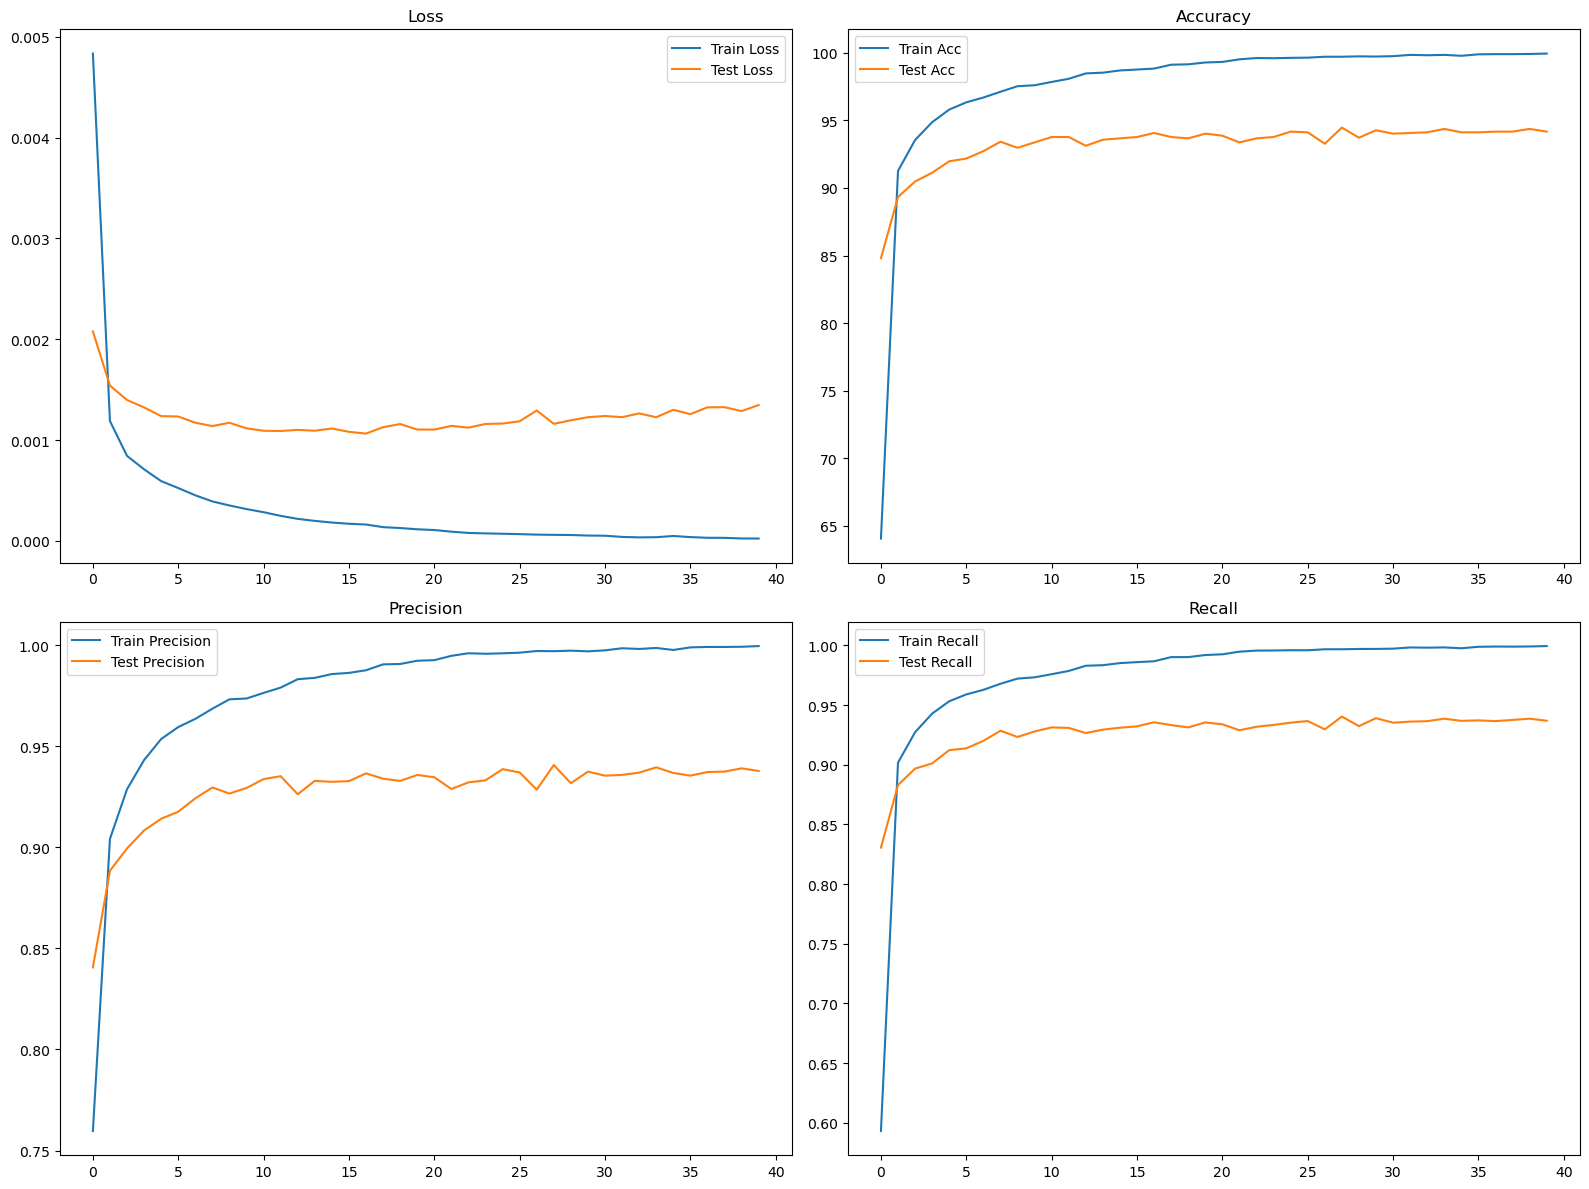

BEST METRIC
Train Loss: 0.0001, Train Acc: 99.7120
Train Precision: 0.9970, Train Recall: 0.9967
Test Loss: 0.0012, Test Acc: 94.4694
Test Precision: 0.9407, Test Recall: 0.9403


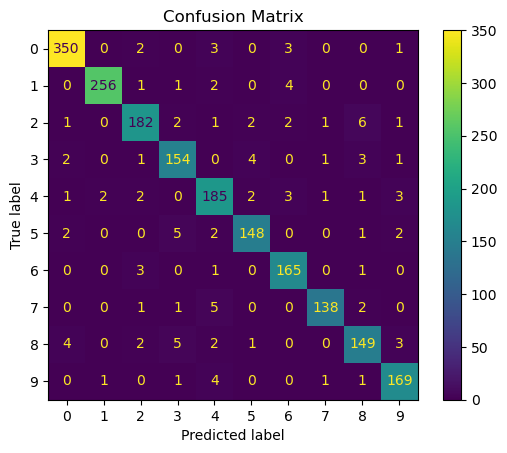

In [12]:
main('mlp')

## ***CNN***

Epoch 1/40
Train Loss: 0.0075, Train Acc: 36.9771
Train Precision: 0.5767, Train Recall: 0.2914
Test Loss: 0.0048, Test Acc: 63.9761
Test Precision: 0.7083, Test Recall: 0.5911



Epoch 2/40
Train Loss: 0.0026, Train Acc: 82.2384
Train Precision: 0.8137, Train Recall: 0.7983
Test Loss: 0.0021, Test Acc: 84.3548
Test Precision: 0.8334, Test Recall: 0.8276



Epoch 3/40
Train Loss: 0.0012, Train Acc: 90.9477
Train Precision: 0.9004, Train Recall: 0.8974
Test Loss: 0.0015, Test Acc: 89.5366
Test Precision: 0.8871, Test Recall: 0.8845



Epoch 4/40
Train Loss: 0.0009, Train Acc: 93.5811
Train Precision: 0.9296, Train Recall: 0.9280
Test Loss: 0.0015, Test Acc: 90.3338
Test Precision: 0.8996, Test Recall: 0.8926



Epoch 5/40
Train Loss: 0.0008, Train Acc: 94.4726
Train Precision: 0.9396, Train Recall: 0.9381
Test Loss: 0.0013, Test Acc: 91.2307
Test Precision: 0.9056, Test Recall: 0.9022



Epoch 6/40
Train Loss: 0.0006, Train Acc: 95.4739
Train Precision: 0.9503, Train Recall: 0.9487
Test Loss: 0.0012, Test Acc: 92.9746
Test Precision: 0.9237, Test Recall: 0.9235



Epoch 7/40
Train Loss: 0.0005, Train Acc: 96.0362
Train Precision: 0.9560, Train Recall: 0.9555
Test Loss: 0.0012, Test Acc: 92.4763
Test Precision: 0.9172, Test Recall: 0.9194



Epoch 8/40
Train Loss: 0.0005, Train Acc: 96.4888
Train Precision: 0.9612, Train Recall: 0.9604
Test Loss: 0.0011, Test Acc: 93.0244
Test Precision: 0.9257, Test Recall: 0.9234



Epoch 9/40
Train Loss: 0.0004, Train Acc: 96.6534
Train Precision: 0.9631, Train Recall: 0.9624
Test Loss: 0.0010, Test Acc: 94.0209
Test Precision: 0.9365, Test Recall: 0.9341



Epoch 10/40
Train Loss: 0.0004, Train Acc: 97.3392
Train Precision: 0.9708, Train Recall: 0.9701
Test Loss: 0.0010, Test Acc: 93.8714
Test Precision: 0.9326, Test Recall: 0.9344



Epoch 11/40
Train Loss: 0.0003, Train Acc: 97.5723
Train Precision: 0.9734, Train Recall: 0.9728
Test Loss: 0.0010, Test Acc: 94.5192
Test Precision: 0.9394, Test Recall: 0.9407



Epoch 12/40
Train Loss: 0.0003, Train Acc: 97.7369
Train Precision: 0.9756, Train Recall: 0.9749
Test Loss: 0.0010, Test Acc: 94.0708
Test Precision: 0.9361, Test Recall: 0.9356



Epoch 13/40
Train Loss: 0.0003, Train Acc: 98.0112
Train Precision: 0.9787, Train Recall: 0.9775
Test Loss: 0.0009, Test Acc: 94.1704
Test Precision: 0.9351, Test Recall: 0.9385



Epoch 14/40
Train Loss: 0.0003, Train Acc: 98.1484
Train Precision: 0.9794, Train Recall: 0.9793
Test Loss: 0.0009, Test Acc: 94.4195
Test Precision: 0.9402, Test Recall: 0.9395



Epoch 15/40
Train Loss: 0.0002, Train Acc: 98.1347
Train Precision: 0.9796, Train Recall: 0.9791
Test Loss: 0.0010, Test Acc: 94.2202
Test Precision: 0.9394, Test Recall: 0.9370



Epoch 16/40
Train Loss: 0.0002, Train Acc: 98.0661
Train Precision: 0.9787, Train Recall: 0.9785
Test Loss: 0.0009, Test Acc: 94.7185
Test Precision: 0.9438, Test Recall: 0.9419



Epoch 17/40
Train Loss: 0.0002, Train Acc: 98.6284
Train Precision: 0.9849, Train Recall: 0.9848
Test Loss: 0.0009, Test Acc: 94.7185
Test Precision: 0.9435, Test Recall: 0.9428



Epoch 18/40
Train Loss: 0.0002, Train Acc: 98.8205
Train Precision: 0.9872, Train Recall: 0.9868
Test Loss: 0.0009, Test Acc: 94.8181
Test Precision: 0.9438, Test Recall: 0.9444



Epoch 19/40
Train Loss: 0.0002, Train Acc: 98.8616
Train Precision: 0.9877, Train Recall: 0.9871
Test Loss: 0.0009, Test Acc: 94.9178
Test Precision: 0.9431, Test Recall: 0.9454



Epoch 20/40
Train Loss: 0.0001, Train Acc: 98.9851
Train Precision: 0.9891, Train Recall: 0.9885
Test Loss: 0.0009, Test Acc: 94.7185
Test Precision: 0.9430, Test Recall: 0.9421



Epoch 21/40
Train Loss: 0.0001, Train Acc: 99.0948
Train Precision: 0.9901, Train Recall: 0.9897
Test Loss: 0.0009, Test Acc: 94.7185
Test Precision: 0.9417, Test Recall: 0.9433



Epoch 22/40
Train Loss: 0.0001, Train Acc: 99.0673
Train Precision: 0.9899, Train Recall: 0.9896
Test Loss: 0.0009, Test Acc: 95.0174
Test Precision: 0.9458, Test Recall: 0.9461



Epoch 23/40
Train Loss: 0.0001, Train Acc: 99.1908
Train Precision: 0.9911, Train Recall: 0.9908
Test Loss: 0.0009, Test Acc: 95.4160
Test Precision: 0.9495, Test Recall: 0.9508



Epoch 24/40
Train Loss: 0.0001, Train Acc: 99.3279
Train Precision: 0.9928, Train Recall: 0.9924
Test Loss: 0.0009, Test Acc: 95.2666
Test Precision: 0.9471, Test Recall: 0.9495



Epoch 25/40
Train Loss: 0.0001, Train Acc: 99.3965
Train Precision: 0.9935, Train Recall: 0.9932
Test Loss: 0.0010, Test Acc: 94.9178
Test Precision: 0.9454, Test Recall: 0.9451



Epoch 26/40
Train Loss: 0.0001, Train Acc: 99.4239
Train Precision: 0.9936, Train Recall: 0.9937
Test Loss: 0.0009, Test Acc: 95.2167
Test Precision: 0.9498, Test Recall: 0.9479



Epoch 27/40
Train Loss: 0.0001, Train Acc: 99.4102
Train Precision: 0.9939, Train Recall: 0.9931
Test Loss: 0.0009, Test Acc: 95.2666
Test Precision: 0.9503, Test Recall: 0.9483



Epoch 28/40
Train Loss: 0.0001, Train Acc: 99.5474
Train Precision: 0.9952, Train Recall: 0.9948
Test Loss: 0.0010, Test Acc: 95.0673
Test Precision: 0.9490, Test Recall: 0.9474



Epoch 29/40
Train Loss: 0.0001, Train Acc: 99.6708
Train Precision: 0.9965, Train Recall: 0.9963
Test Loss: 0.0009, Test Acc: 95.2167
Test Precision: 0.9490, Test Recall: 0.9478



Epoch 30/40
Train Loss: 0.0001, Train Acc: 99.6983
Train Precision: 0.9969, Train Recall: 0.9966
Test Loss: 0.0009, Test Acc: 95.2167
Test Precision: 0.9495, Test Recall: 0.9482



Epoch 31/40
Train Loss: 0.0001, Train Acc: 99.6983
Train Precision: 0.9968, Train Recall: 0.9967
Test Loss: 0.0009, Test Acc: 95.5157
Test Precision: 0.9511, Test Recall: 0.9520



Epoch 32/40
Train Loss: 0.0001, Train Acc: 99.7120
Train Precision: 0.9969, Train Recall: 0.9967
Test Loss: 0.0009, Test Acc: 95.5655
Test Precision: 0.9527, Test Recall: 0.9521



Epoch 33/40
Train Loss: 0.0001, Train Acc: 99.6571
Train Precision: 0.9963, Train Recall: 0.9962
Test Loss: 0.0009, Test Acc: 95.2666
Test Precision: 0.9502, Test Recall: 0.9484



Epoch 34/40
Train Loss: 0.0000, Train Acc: 99.7943
Train Precision: 0.9979, Train Recall: 0.9977
Test Loss: 0.0010, Test Acc: 95.4659
Test Precision: 0.9503, Test Recall: 0.9511



Epoch 35/40
Train Loss: 0.0001, Train Acc: 99.8080
Train Precision: 0.9979, Train Recall: 0.9978
Test Loss: 0.0010, Test Acc: 95.5655
Test Precision: 0.9520, Test Recall: 0.9519



Epoch 36/40
Train Loss: 0.0000, Train Acc: 99.8491
Train Precision: 0.9985, Train Recall: 0.9983
Test Loss: 0.0010, Test Acc: 95.5655
Test Precision: 0.9523, Test Recall: 0.9522



Epoch 37/40
Train Loss: 0.0000, Train Acc: 99.9040
Train Precision: 0.9991, Train Recall: 0.9989
Test Loss: 0.0010, Test Acc: 95.3164
Test Precision: 0.9482, Test Recall: 0.9502



Epoch 38/40
Train Loss: 0.0000, Train Acc: 99.7943
Train Precision: 0.9979, Train Recall: 0.9978
Test Loss: 0.0011, Test Acc: 95.2666
Test Precision: 0.9512, Test Recall: 0.9477



Epoch 39/40
Train Loss: 0.0000, Train Acc: 99.7806
Train Precision: 0.9977, Train Recall: 0.9975
Test Loss: 0.0010, Test Acc: 95.5157
Test Precision: 0.9511, Test Recall: 0.9520



Epoch 40/40
Train Loss: 0.0000, Train Acc: 99.9314
Train Precision: 0.9994, Train Recall: 0.9992
Test Loss: 0.0010, Test Acc: 95.4659
Test Precision: 0.9497, Test Recall: 0.9513



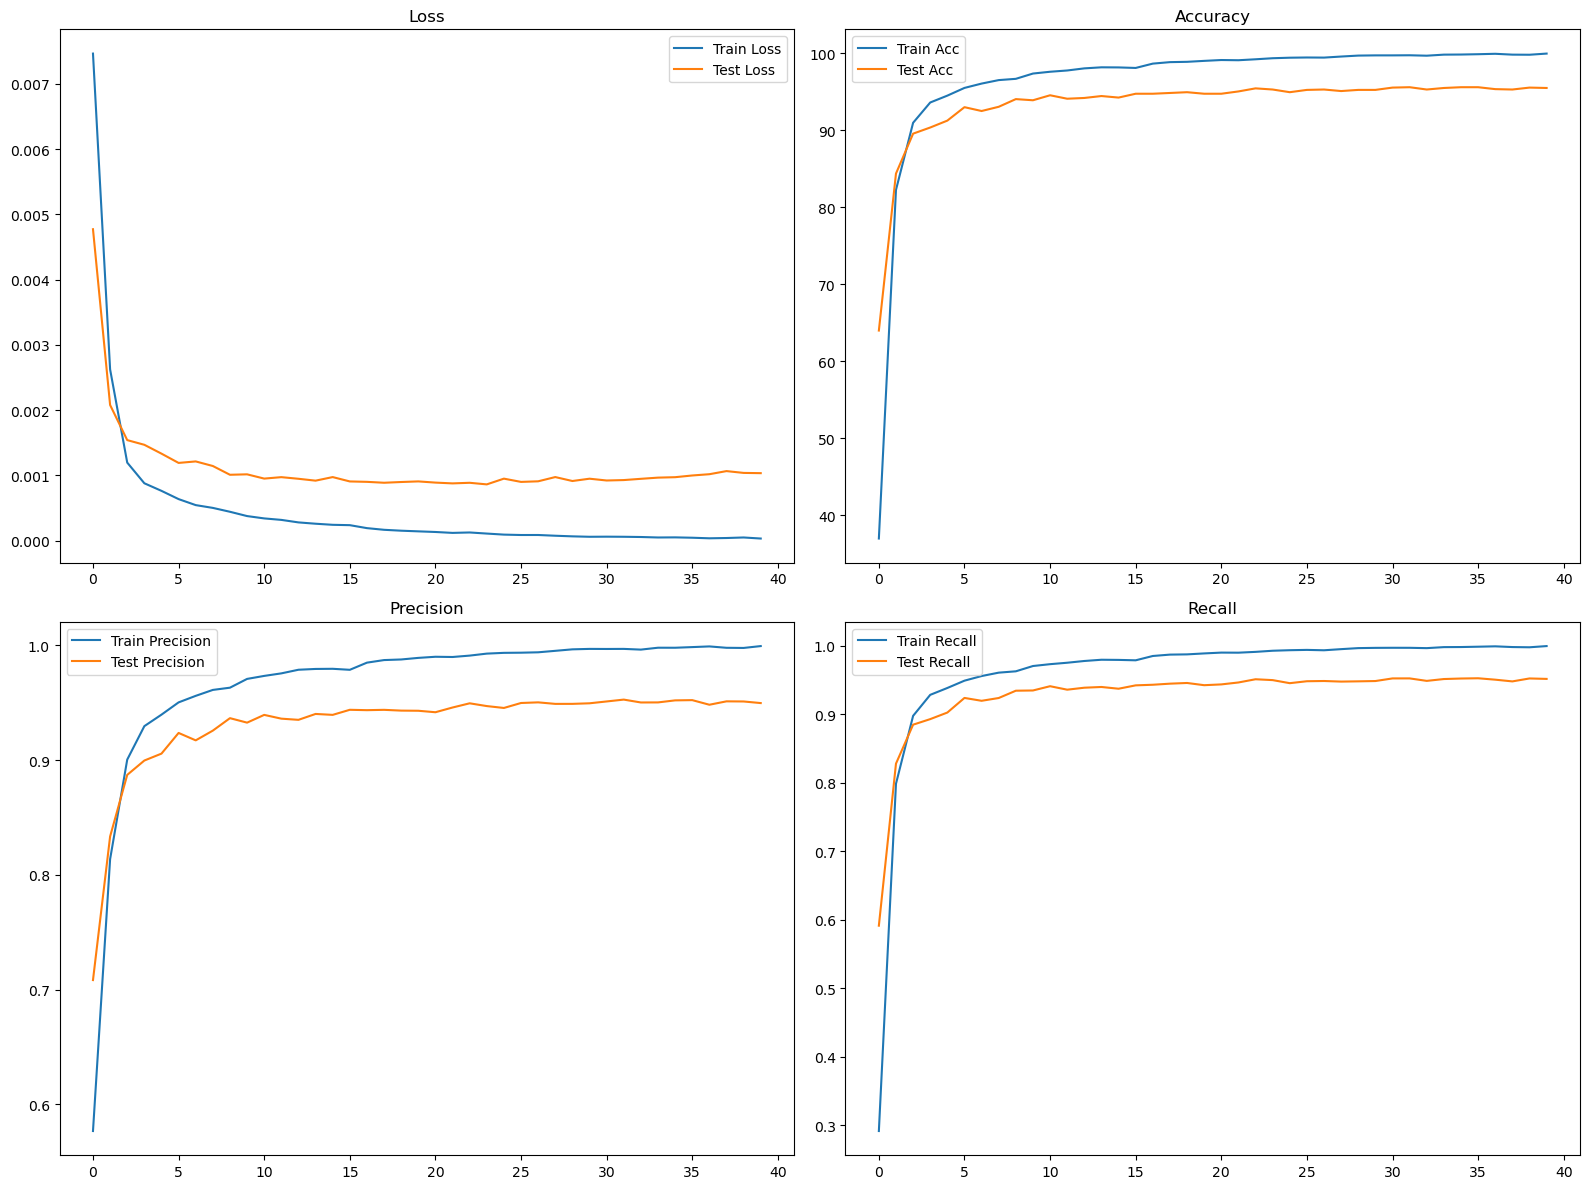

BEST METRIC
Train Loss: 0.0001, Train Acc: 99.7120
Train Precision: 0.9969, Train Recall: 0.9967
Test Loss: 0.0009, Test Acc: 95.5655
Test Precision: 0.9527, Test Recall: 0.9521


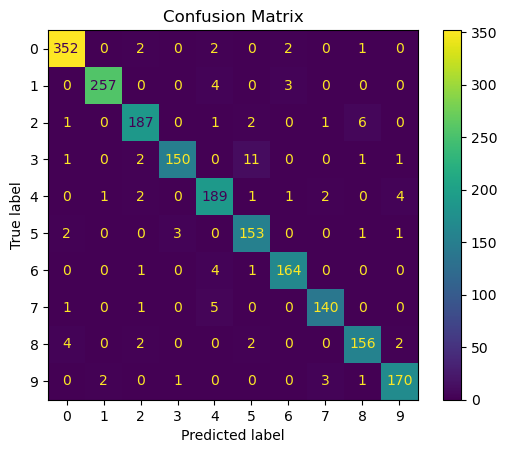

In [13]:
main('cnn')

In [14]:
writer.close()

The tensorboard logs can be visualized using the following command:
```bash
tensorboard --logdir=runs --bind_all
```